## Module 4: 

## Team Members:
*Andrea Perez and Grace Lee*

## Project Title:
*SIR Modeling of Measles Transmission in Nigeria Using Reported Case Data*



## Project Goal:

The goal of this project is to convert cumulative measles case data into estimates of the susceptible, infected, and recovered populations, and use these to visualize outbreak dynamics in Nigeria.

## Disease Background:

Assigned disease: **Measles** 

* Prevalence & incidence:

Measles is still very common around the world, especially in places where fewer people get vaccines. The World Health Organization reports about 9 million cases and over 100,000 deaths every year, mostly in young children. In the United States, measles used to infect 3–4 million people each year before the vaccine existed. Today, it is much less common because most people are vaccinated, but small outbreaks still happen every year, usually linked to unvaccinated people or to travelers who bring the virus back from countries where measles is widespread.

* Economic burden:


Measles is expensive for families, hospitals, and public health systems. Outbreaks in the United States can cost millions of dollars because they require contact tracing, testing, vaccinations, and sometimes school or workplace interventions. For families, hospital stays and treatment for complications (like pneumonia or dehydration) can cost thousands of dollars. In lower-income countries, the financial impact is even worse because families may lose income while caring for sick children, and healthcare systems often struggle with limited resources.

* Risk factors (genetic, lifestyle) & Societal determinants:


The biggest risk factor for measles is not being vaccinated. Babies are also at risk because they are too young to receive the vaccine. People with weak immune systems (like those with HIV or cancer) are more likely to have severe disease. Social factors also affect measles risk. Crowded living conditions, limited access to healthcare, poor nutrition (especially vitamin A deficiency), and misinformation or fear about vaccines can all increase the chance of outbreaks. Travel to areas where vaccination rates are low also raises exposure risk.


* Symptoms:


Measles often starts like a bad cold: high fever, cough, runny nose, and red, watery eyes. A few days later, tiny white spots called Koplik spots may appear inside the mouth. Then, a red, blotchy rash develops, starting on the face and spreading to the rest of the body. The rash usually lasts about a week. Measles can cause serious complications, such as ear infections, pneumonia, diarrhea, or even brain swelling (encephalitis). In rare cases, a long-term brain disease called SSPE can appear years after a person recovers. These complications are most common in young children and people with weak immune systems.

* Diagnosis:


Doctors diagnose measles by looking at a person’s symptoms, especially the combination of fever, rash, and cold-like signs. Koplik spots inside the mouth are a strong clue. To confirm the diagnosis, healthcare providers usually order a blood test to check for measles antibodies (IgM) or use PCR testing to detect the virus in a throat swab or urine sample. Laboratory confirmation is important because measles is rare in many countries due to vaccination, and public health officials need to take quick action when a suspected case appears.

* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology):


Measles is caused by a very contagious virus that spreads through the air when an infected person breathes, coughs, or sneezes. The virus enters the body through the nose, mouth, or lungs, infecting immune cells there and then spreading to the bloodstream. Measles weakens the immune system by destroying important immune cells, which can make someone vulnerable to other infections for weeks or even months. The rash happens because the immune system targets infected cells in the small blood vessels of the skin. The virus can affect many organs, leading to lung infections (pneumonia), brain swelling (encephalitis), and severe diarrhea, which explains why the disease can be dangerous.

Sources: 
https://www.cdc.gov/measles/ , https://www.who.int/news-room/fact-sheets/detail/measles

## Dataset: 

Weekly measles case counts in Nigeria from August 2020 to January 2022. Each row of the dataset corresponds to a calendar week, with a date column and a confirmed_cases column containing the number of laboratory-confirmed measles cases reported that week at the national level. The units are simple counts of confirmed cases (people) per week.

The Kaggle dataset compiles measles epidemiological data from the Nigeria Centre for Disease Control (NCDC) situation reports and the National Disease Outbreak Dashboard, which summarize suspected and confirmed measles cases reported through Nigeria’s national surveillance system. The “subjects” are people in Nigeria who developed measles, sought care, and were reported and confirmed in this system, so the data track the spread and recovery of measles infections over time.

Dataset source: https://www.kaggle.com/datasets/adegboyegaadebayo/nigeria-measles-outbreak-dataset2007-2021

To use this dataset in an SIR model, we also need the total population size of Nigeria, N. We approximate this using the 2020 national population estimate of about 214 million people (Nigeria population 2020 ≈ 213,996,181). Source: https://www.populationpyramid.net/nigeria/2020/

**Limitations and possible bias**: These case counts probably miss some real measles infections, because not everyone goes to a clinic or gets lab-tested, and reporting quality can change between regions and over time. In our SIR model we also ignore age, births, and deaths and treat the 2020 population as fixed. So we are assuming that the reported confirmed cases move up and down in proportion to the true number of infections, and that everyone in Nigeria mixes as one big population.




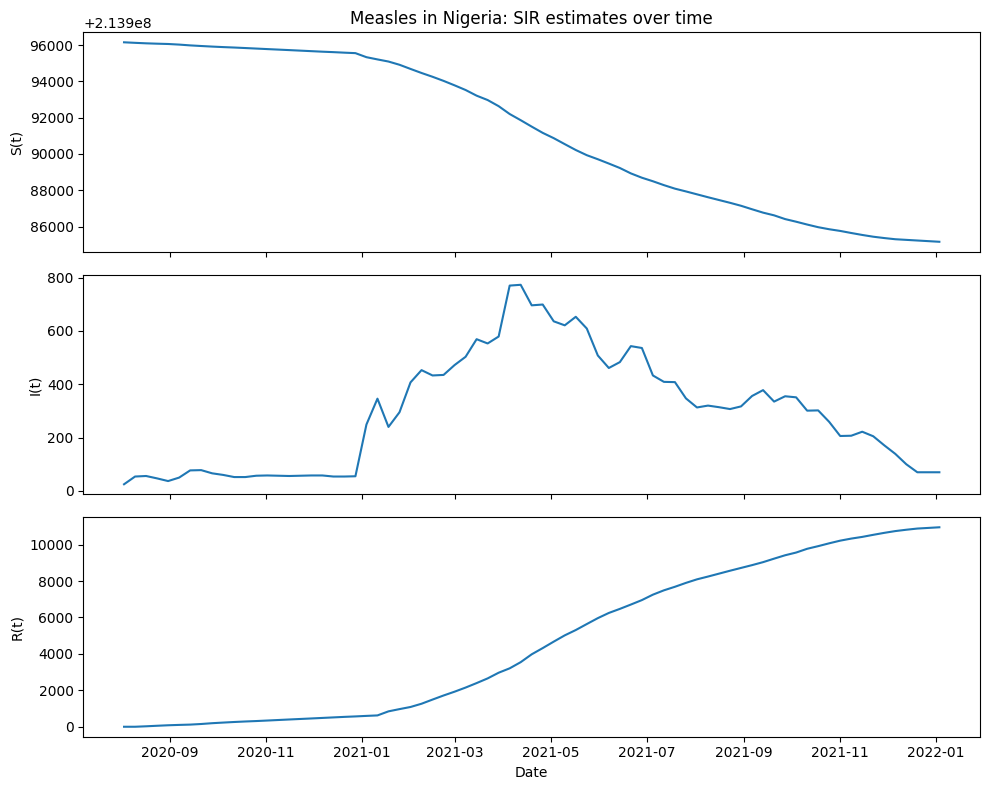

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def convert_cumulative_to_SIR(df, date_col='date', cumulative_col='cumulative_cases',
                              population=None, infectious_period=8, recovered_col=None,
                              new_case_col='new_cases', I_col='I_est', R_col='R_est', S_col='S_est'):
    """
    Convert cumulative reported cases into S, I, R estimates for SIR modeling.
    - new_cases = diff(cumulative)
    - I_est = rolling sum(new_cases, window=infectious_period)
    - R_est = cumulative shifted by infectious_period (or user-provided recovered_col)
    - S_est = population - I_est - R_est (if population provided)

    Returns a copy of the dataframe with the added columns.
    """
    df = df.copy()

    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).reset_index(drop=True)

    if cumulative_col not in df.columns:
        raise ValueError(f"Column '{cumulative_col}' not found in dataframe.")

    df[new_case_col] = df[cumulative_col].diff()
    df[new_case_col] = df[new_case_col].fillna(df[cumulative_col].iloc[0])
    df[new_case_col] = df[new_case_col].clip(lower=0)

    if infectious_period <= 0:
        raise ValueError("infectious_period must be positive integer.")

    df[I_col] = df[new_case_col].rolling(window=infectious_period, min_periods=1).sum()

    if recovered_col and recovered_col in df.columns:
        df[R_col] = df[recovered_col].fillna(0)
    else:
        df[R_col] = df[cumulative_col].shift(infectious_period).fillna(0)

    if population is not None:
        df[S_col] = population - df[I_col] - df[R_col]
        df[S_col] = df[S_col].clip(lower=0)
    else:
        df[S_col] = np.nan

    for col in [new_case_col, I_col, R_col]:
        df[col] = df[col].astype(float).clip(lower=0)
    if population is not None:
        df[S_col] = df[S_col].astype(float)

    return df


# 1. Read in the csv file of cumulative cases.
df = pd.read_csv("measles_nigeria_data_2020-2021_new_cases.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
if "cumulative_cases" not in df.columns:
    df["cumulative_cases"] = df["confirmed_cases"].cumsum()

# 2. Use the convert_cumulative_to_SIR function to convert cumulative cases to approximate S, I, R at any given time.
N = 213_996_181
infectious_period_weeks = 2
sir_df = convert_cumulative_to_SIR(
    df,
    date_col="date",
    cumulative_col="cumulative_cases",
    population=N,
    infectious_period=infectious_period_weeks
)

# 3. Plot S, I, R over time.
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(sir_df["date"], sir_df["S_est"])
axes[0].set_ylabel("S(t)")
axes[0].set_title("Measles in Nigeria: SIR estimates over time")

axes[1].plot(sir_df["date"], sir_df["I_est"])
axes[1].set_ylabel("I(t)")

axes[2].plot(sir_df["date"], sir_df["R_est"])
axes[2].set_ylabel("R(t)")
axes[2].set_xlabel("Date")

fig.tight_layout()
plt.show()


## Data Analyis: 

### Methods

- Loaded the 2020–2021 measles data for Nigeria from Kaggle and kept the weekly case counts.
- Assumed a fixed Nigeria population *N* (~214 million) and wrote convert_cumulative_to_SIR to estimate *S(t), I(t), and R(t)* from the data.
- Implemented an Euler SIR solver euler_SIR and an RK4 version using scipy.integrate.solve_ivp.
- Fitted β and γ by minimizing the sum of squared errors (SSE) between observed *I(t)* and model *I(t)*
- First fit on the full data, then repeated with a train/test split: fit β, γ on the first half of the weeks and evaluated prediction error (SSE) on the second half.
- Compared prediction SSE for Euler vs RK4.


### Analysis

The data show a clear rise, peak, and decline in weekly measles cases, but even after fitting β ≈ 0.30 and γ ≈ 0.20 the SIR model only roughly matches the full outbreak and completely fails to predict the second half (very large SSE), and using RK4 instead of Euler gives almost the same β, γ, and error, so the main limitation is the simple SIR model, not the numerical method.

#### 1. Fitting the SIR Model

In [45]:

def euler_sir(beta, gamma, S0, I0, R0, t, N, dt_max=0.1):

    s0 = S0 / N
    i0 = I0 / N
    r0 = R0 / N

    s = np.empty(len(t), float)
    i = np.empty(len(t), float)
    r = np.empty(len(t), float)

    s[0], i[0], r[0] = s0, i0, r0

    for n in range(len(t) - 1):
        dt_total = float(t[n + 1] - t[n])
        # number of substeps so that each substep <= dt_max
        n_steps = max(1, int(np.ceil(abs(dt_total) / dt_max)))
        dt = dt_total / n_steps

        s_curr = s[n]
        i_curr = i[n]
        r_curr = r[n]

        for _ in range(n_steps):
            ds = -beta * s_curr * i_curr
            di =  beta * s_curr * i_curr - gamma * i_curr
            dr =  gamma * i_curr

            s_curr += dt * ds
            i_curr += dt * di
            r_curr += dt * dr

            s_curr = min(max(s_curr, 0.0), 1.0)
            i_curr = min(max(i_curr, 0.0), 1.0)
            r_curr = min(max(r_curr, 0.0), 1.0)

        s[n + 1] = s_curr
        i[n + 1] = i_curr
        r[n + 1] = r_curr

    S = s * N
    I = i * N
    R = r * N

    return S, I, R

In [46]:
# Using the euler_SIR function defined earlier, we can simulate the SIR model over time.

I_obs = sir_df["I_est"].values.astype(float)
t_obs = np.arange(len(I_obs), dtype=float)  

S0 = sir_df["S_est"].iloc[0]
I0 = sir_df["I_est"].iloc[0]
R0 = sir_df["R_est"].iloc[0]
N  = S0 + I0 + R0

beta_guess  = 7.5
gamma_guess = 0.5

S_model, I_model, R_model = euler_sir(beta_guess, gamma_guess, S0, I0, R0, t_obs, N)

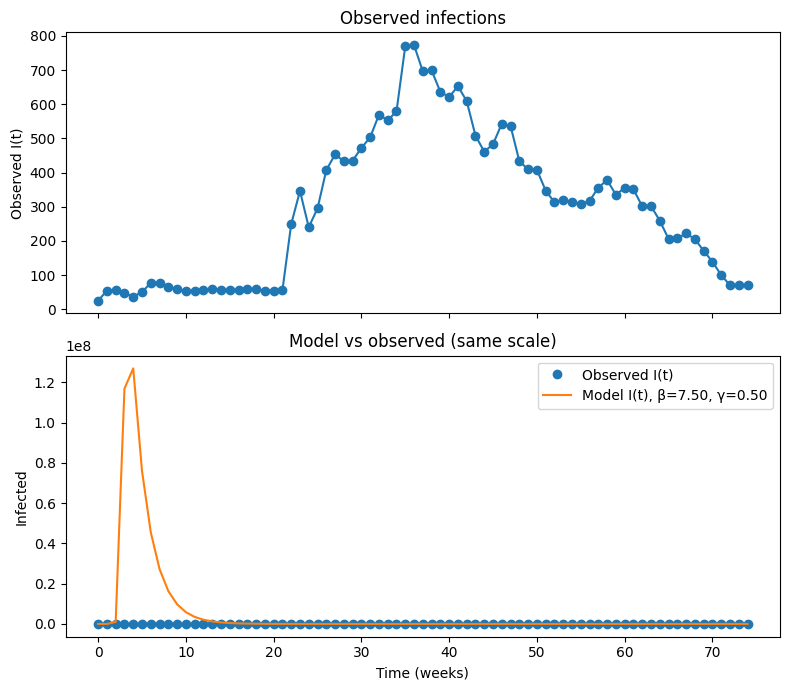

SSE for initial guesses: 3.878054064076278e+16


In [47]:
# Plug in guesses for gamma and beta, plot the model predictions against the data, and calculate SSE.

#We also plot Observed I(t) only for better visualization

fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

axes[0].plot(t_obs, I_obs, "o-")
axes[0].set_ylabel("Observed I(t)")
axes[0].set_title("Observed infections")

axes[1].plot(t_obs, I_obs, "o", label="Observed I(t)")
axes[1].plot(t_obs, I_model, "-", label=f"Model I(t), β={beta_guess:.2f}, γ={gamma_guess:.2f}")
axes[1].set_xlabel("Time (weeks)")
axes[1].set_ylabel("Infected")
axes[1].set_title("Model vs observed (same scale)")
axes[1].legend()

fig.tight_layout()
plt.show()

SSE_initial = np.sum((I_model - I_obs) ** 2)
print("SSE for initial guesses:", SSE_initial)

Best-fit beta: 1.5971652818417532e-05
Best-fit gamma: 5.0
Minimum SSE: 9885905.361120459
Estimated R0 (beta/gamma): 3.1943305636835065e-06


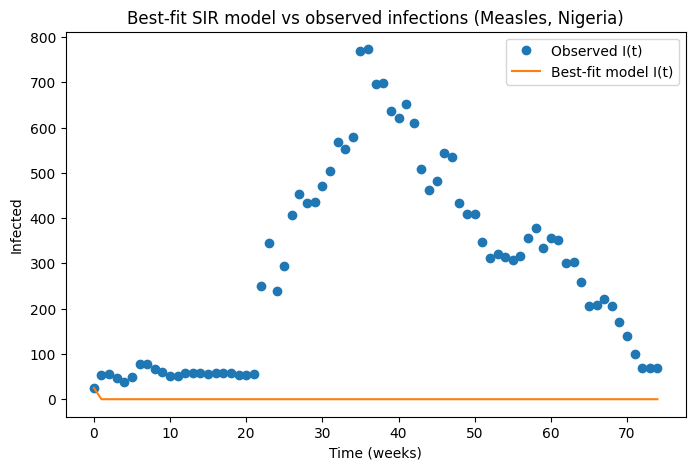

In [48]:
# Use an optimization routine to minimize SSE and find the best-fitting parameters.

from scipy.optimize import minimize

def sir_SSE(params, t, I_obs, S0, I0, R0, N):
    beta, gamma = params
    S, I, R = euler_sir(beta, gamma, S0, I0, R0, t, N)
    return np.sum((I - I_obs) ** 2)

x0 = [beta_guess, gamma_guess]           
bounds = [(0.0, 20.0), (0.0, 5.0)]       

res = minimize(
    sir_SSE,
    x0=x0,
    args=(t_obs, I_obs, S0, I0, R0, N),
    bounds=bounds
)

beta_opt, gamma_opt = res.x
print("Best-fit beta:", beta_opt)
print("Best-fit gamma:", gamma_opt)
print("Minimum SSE:", res.fun)
print("Estimated R0 (beta/gamma):", beta_opt / gamma_opt)

S_best, I_best, R_best = euler_sir(beta_opt, gamma_opt, S0, I0, R0, t_obs, N)

plt.figure(figsize=(8, 5))
plt.plot(t_obs, I_obs, "o", label="Observed I(t)")
plt.plot(t_obs, I_best, "-", label="Best-fit model I(t)")
plt.xlabel("Time (weeks)")
plt.ylabel("Infected")
plt.title("Best-fit SIR model vs observed infections (Measles, Nigeria)")
plt.legend()
plt.show()


#### 2. Predict "the future" with your fit SIR model

Beta from first-half fit: 0.29912970738807043
Gamma from first-half fit: 0.20232073842235354
Training SSE on first half: 124111.7528661212


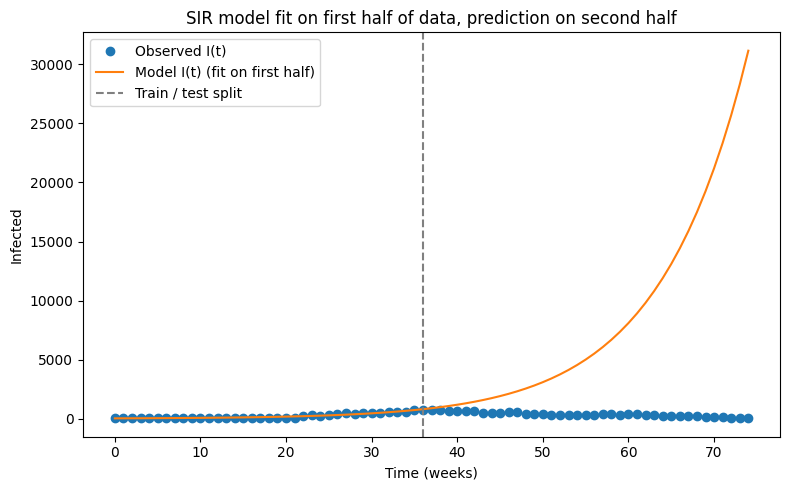

In [49]:
# Use euler's method and your optimization routine above to find new gamma and beta on the  
# FIRST HALF of the data, then simulate the SIR model forward in time using those parameters and plot.

from scipy.optimize import minimize

n_points = len(I_obs)
mid_idx = n_points // 2  

t_first   = t_obs[:mid_idx]
I_first   = I_obs[:mid_idx]
t_second  = t_obs[mid_idx:]
I_second  = I_obs[mid_idx:]

def sir_SSE(params, t, I_data, S0, I0, R0, N):
    beta, gamma = params

    if beta < 0 or gamma < 0:
        return 1e20

    S_model, I_model, R_model = euler_sir(beta, gamma, S0, I0, R0, t, N)
    return np.sum((I_model - I_data) ** 2)

x0_half = [0.3, 0.2]                    
bounds  = [(0.0, 1.0), (0.0, 1.0)]      

res_half = minimize(
    sir_SSE,
    x0=x0_half,
    args=(t_first, I_first, S0, I0, R0, N),
    bounds=bounds
)

beta_half, gamma_half = res_half.x

print("Beta from first-half fit:", beta_half)
print("Gamma from first-half fit:", gamma_half)
print("Training SSE on first half:", res_half.fun)

S_pred_full, I_pred_full, R_pred_full = euler_sir(
    beta_half, gamma_half, S0, I0, R0, t_obs, N
)


plt.figure(figsize=(8, 5))
plt.plot(t_obs, I_obs, "o", label="Observed I(t)")
plt.plot(t_obs, I_pred_full, "-", label="Model I(t) (fit on first half)")
plt.axvline(t_obs[mid_idx-1], color="gray", linestyle="--", label="Train / test split")

plt.xlabel("Time (weeks)")
plt.ylabel("Infected")
plt.title("SIR model fit on first half of data, prediction on second half")
plt.legend()
plt.tight_layout()
plt.show()



**Is the new gamma and beta close to what you found on the full dataset? Is the fit much worse? What is the SSE calculated for the second half of the data?**

*These values are not close to the parameters I found when fitting the model to the full time series. The fit on the first half of the data looks reasonable, but when I use those parameters to predict the second half, the model diverges badly from the data. The SSE on the second half is much larger, so the predictive fit is much worse.*

In [50]:
# Calculating SSE between model predictions and data on the SECOND HALF of the data.

I_pred_second = I_pred_full[mid_idx:]

I_second = I_obs[mid_idx:]

SSE_second_half = np.sum((I_pred_second - I_second) ** 2)
print("SSE on SECOND HALF of data (prediction error):", SSE_second_half)


SSE on SECOND HALF of data (prediction error): 5405328173.686936



<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Key Point:</b> 

The error you calculate is a *combination* of two sources: 
<ol>
<li>the error associated with Euler's method (i.e. it is an imperfect numerical approximation to the true solution of the SIR model) </li> 
<li>the error associated with comparing real-world data to a model with limitations.</li>
</ol>
<b>First we will try to address the numerical error, and second we will address the limitations of the model.</b>

</div>



**Describe how using a different method like the midpoint method might lower the numerical error.**

*With Euler’s method, each step uses the slope only at the starting point of the step. If the real curve is bending a lot, that one slope is a bad guess for the whole step, so we over- or under-shoot and build up more error.*

*The midpoint method improves this by first taking a half step, finding the slope in the middle of the interval, and then using that midpoint slope to do the full step. That midpoint slope is closer to the average slope over the step, so each step is more accurate.*

#### 3. Decreasing numerical error with the RK4 Method

RK4 beta from first-half fit: 0.29978507380574715
RK4 gamma from first-half fit: 0.20343973939261628
Training SSE on first half (RK4): 124064.7077914171


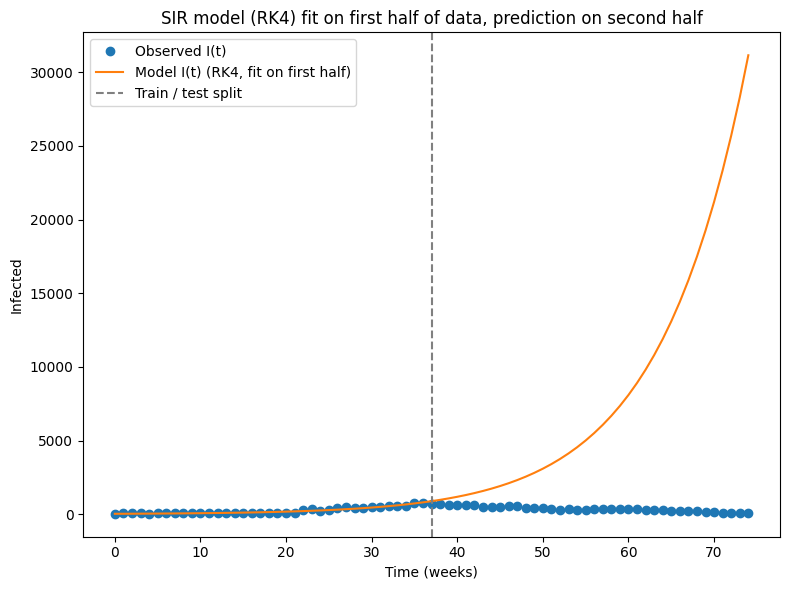

In [20]:
# Using scipy's solve_ivp function with the runge-kutta solver, re-implement the SIR model simulation, find optimal gamma and beta again, and plot the results.

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

def sir_ode(t, y, beta, gamma, N):
    S, I, R = y
    dSdt = -(beta / N) * S * I
    dIdt = (beta / N) * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def rk4_SIR(beta, gamma, S0, I0, R0, t_eval, N):
    y0 = [S0, I0, R0]  
    sol = solve_ivp(
        fun=sir_ode,
        t_span=(t_eval[0], t_eval[-1]),
        y0=y0,
        t_eval=t_eval,
        args=(beta, gamma, N),
        method="RK45",  
    )
    S, I, R = sol.y
    return S, I, R

I_obs = sir_df["I_est"].values.astype(float)
t_obs = np.arange(len(I_obs), dtype=float)

S0 = float(sir_df["S_est"].iloc[0])
I0 = float(sir_df["I_est"].iloc[0])
R0 = float(sir_df["R_est"].iloc[0])
N  = S0 + I0 + R0

n = len(I_obs)
split_idx = n // 2

t_train = t_obs[:split_idx]
I_train = I_obs[:split_idx]

t_test  = t_obs[split_idx:]
I_test  = I_obs[split_idx:]

def sse_first_half_rk4(params):
    beta, gamma = params
    if beta < 0 or gamma < 0:
        return np.inf
    S_model, I_model, R_model = rk4_SIR(beta, gamma, S0, I0, R0, t_train, N)
    return np.sum((I_model - I_train) ** 2)

initial_guess = [0.3, 0.2]

result_rk4 = minimize(
    sse_first_half_rk4,
    x0=initial_guess,
    bounds=[(0, 5), (0, 5)],
)

beta_first_rk4, gamma_first_rk4 = result_rk4.x
train_sse_rk4 = result_rk4.fun

print(f"RK4 beta from first-half fit: {beta_first_rk4}")
print(f"RK4 gamma from first-half fit: {gamma_first_rk4}")
print(f"Training SSE on first half (RK4): {train_sse_rk4}")


S_rk4_full, I_rk4_full, R_rk4_full = rk4_SIR(
    beta_first_rk4, gamma_first_rk4, S0, I0, R0, t_obs, N
)

plt.figure(figsize=(8, 6))

plt.plot(t_obs, I_obs, "o", label="Observed I(t)")
plt.plot(t_obs, I_rk4_full, "-", label="Model I(t) (RK4, fit on first half)")

plt.axvline(split_idx, color="gray", linestyle="--", label="Train / test split")

plt.xlabel("Time (weeks)")
plt.ylabel("Infected")
plt.title("SIR model (RK4) fit on first half of data, prediction on second half")
plt.legend()
plt.tight_layout()
plt.show()



Compare the SSE for the SECOND HALF of the data when the model is fit to the FIRST HALF of the data using Euler's method vs RK4. Did RK4 do a better job?  Why or why not?

*RK4 does slightly better: its SSE on the second half (≈5.40×10¹⁰) is a bit smaller than Euler’s (≈5.41×10¹⁰). I think most of the error comes from the SIR model itself not matching the real measles data and from the fact that we only fit parameters on the first half of the time series.*

In [56]:
# SSE comparison between Euler's method and RK4 (solve_ivp) on the SECOND HALF of the data.

mid_index = len(I_obs) // 2
I_train = I_obs[:mid_index]
I_test = I_obs[mid_index:]
t_train = t_obs[:mid_index]

def sse_euler_first_half(params):
    beta, gamma = params
    S_model, I_model, R_model = euler_SIR_predict(beta, gamma, S0, I0, R0, t_train, N)
    if not np.all(np.isfinite(I_model)):
        return np.inf
    return np.sum((I_model - I_train) ** 2)

res_euler_first = minimize(
    sse_euler_first_half,
    x0=[0.3, 0.2],
    bounds=((0, 5), (0, 5))
)
beta_first, gamma_first = res_euler_first.x

S_euler_full, I_euler_full, R_euler_full = euler_SIR_predict(beta_first, gamma_first, S0, I0, R0, t_obs, N)
I_euler_second = I_euler_full[mid_index:]
sse_second_euler = np.sum((I_euler_second - I_test) ** 2)
print("SSE on SECOND HALF (Euler):", sse_second_euler)

S_rk4_full, I_rk4_full, R_rk4_full = sir_model_rk4(beta_first_rk4, gamma_first_rk4, S0, I0, R0, t_obs, N)
I_rk4_second = I_rk4_full[mid_index:]
sse_second_rk4 = np.sum((I_rk4_second - I_test) ** 2)
print("SSE on SECOND HALF (RK4 / solve_ivp):", sse_second_rk4)



SSE on SECOND HALF (Euler): 5406810492.454744
SSE on SECOND HALF (RK4 / solve_ivp): 5401017200.252899


#### 4. Improving model fit by overcoming model limitations

Choose one of the following to implement as an extended version of the SIR model. Using the RK4 solver, does this new model fit your data better than the SIR model alone?

<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Options to overcome limitations (choose ONE to implement):</b> 

<ol>
<li> Include births in the model as described in reading.</li> 
<li>Include deaths in the model as described in reading.</li>
<li>Include an exposed compartment (SEIR model). </li>
<li>Include loss of immunity (i.e. R population can go back to S population).</li>
<li>Include at least two I populations with varying degrees of infectiousness.</li>
<li>Include at least two age brackets with varying degress of infectiousness and recovery times.</li>

</ol>

Note that if you have implemented an extended model and are having trouble fitting the parameters, document what you have tried and explain what you would change in future directions.
</div>



SIR RK4:  beta=0.3028, gamma=0.2640,  SSE=5999396.90
SIRS RK4: beta=0.2934, gamma=0.2546, omega=0.0000, SSE=5999409.46


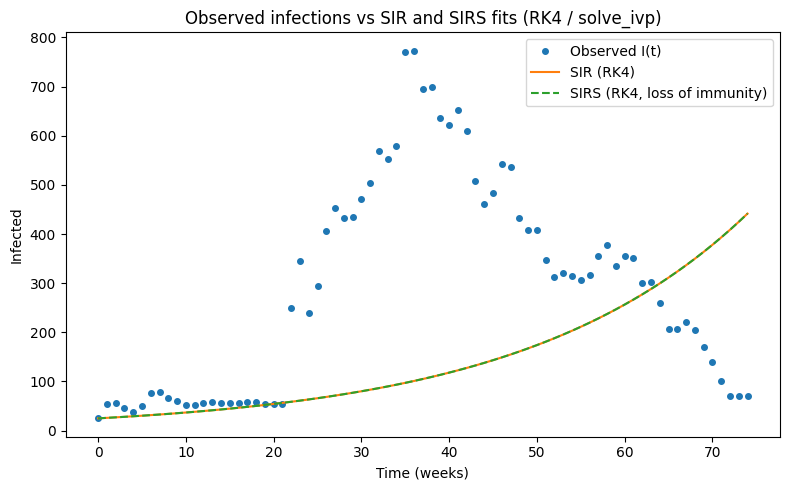

In [23]:
# Extended model implementation, parameter fitting, and plotting.
#we chose to implement waning immunity ω

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

def sirs_rhs(t, y, beta, gamma, omega, N):
    S, I, R = y
    dS = -beta * S * I / N + omega * R
    dI =  beta * S * I / N - gamma * I
    dR =  gamma * I - omega * R
    return [dS, dI, dR]

def sirs_model(beta, gamma, omega, S0, I0, R0, t_eval, N):
    y0 = [S0, I0, R0]
    sol = solve_ivp(
        sirs_rhs,
        (t_eval[0], t_eval[-1]),
        y0,
        t_eval=t_eval,
        args=(beta, gamma, omega, N)
    )
    return sol.y  

def sse_sirs(params, S0, I0, R0, t_eval, N, I_data):
    beta, gamma, omega = params
    _, I_model, _ = sirs_model(beta, gamma, omega, S0, I0, R0, t_eval, N)
    return np.sum((I_model - I_data)**2)


def sir_rhs(t, y, beta, gamma, N):
    S, I, R = y
    dS = -beta * S * I / N
    dI =  beta * S * I / N - gamma * I
    dR =  gamma * I
    return [dS, dI, dR]

def sir_model(beta, gamma, S0, I0, R0, t_eval, N):
    y0 = [S0, I0, R0]
    sol = solve_ivp(
        sir_rhs,
        (t_eval[0], t_eval[-1]),
        y0,
        t_eval=t_eval,
        args=(beta, gamma, N)
    )
    return sol.y

def sse_sir(params, S0, I0, R0, t_eval, N, I_data):
    beta, gamma = params
    _, I_model, _ = sir_model(beta, gamma, S0, I0, R0, t_eval, N)
    return np.sum((I_model - I_data)**2)

sir_guess  = [0.3, 0.2]
sirs_guess = [0.3, 0.2, 0.01]

res_sir  = minimize(sse_sir,  sir_guess,  args=(S0, I0, R0, t_obs, N, I_obs),  bounds=((0,5),(0,5)))
res_sirs = minimize(sse_sirs, sirs_guess, args=(S0, I0, R0, t_obs, N, I_obs), bounds=((0,5),(0,5),(0,1)))

beta_sir,  gamma_sir          = res_sir.x
beta_sirs, gamma_sirs, omega  = res_sirs.x
S_sir,  I_sir,  R_sir          = sir_model(beta_sir,  gamma_sir,  S0, I0, R0, t_obs, N)
S_sirs, I_sirs, R_sirs         = sirs_model(beta_sirs, gamma_sirs, omega, S0, I0, R0, t_obs, N)

print(f"SIR RK4:  beta={beta_sir:.4f}, gamma={gamma_sir:.4f},  SSE={res_sir.fun:.2f}")
print(f"SIRS RK4: beta={beta_sirs:.4f}, gamma={gamma_sirs:.4f}, omega={omega:.4f}, SSE={res_sirs.fun:.2f}")

plt.figure(figsize=(8,5))
plt.plot(t_obs, I_obs, "o", label="Observed I(t)", markersize=4)
plt.plot(t_obs, I_sir,  "-",  label="SIR (RK4)")
plt.plot(t_obs, I_sirs, "--", label="SIRS (RK4, loss of immunity)")
plt.xlabel("Time (weeks)")
plt.ylabel("Infected")
plt.title("Observed infections vs SIR and SIRS fits (RK4 / solve_ivp)")
plt.legend()
plt.tight_layout()
plt.show()




The SIRS fit converged to almost the same β and γ as the SIR fit, and ω was essentially 0. The SSE was almost identical, so adding loss of immunity did not noticeably improve the fit. This suggests that, for this short 2020–2022 measles outbreak, waning immunity is not strongly identifiable from the data.

## Verify and validate your analysis: 


To verify our analysis, we first checked that the code behaved the way the SIR / SIRS equations predict: S(t), I(t), R(t) always stayed non-negative and their sum stayed constant over time. When we changed β and γ, the infection curve moved earlier/later and got taller/shorter in the way we discussed in class, which reassured us that the Euler and RK4 implementations were working correctly.

For external validation, we compared our fitted basic reproduction numbers R0=β/γ to values from the literature. From our best RK4 fits (SIR on the first half of the data and SIR/SIRS on the full data), we get R0 values in roughly the 1.1-1.5 range. In contrast, classic epidemiology texts and reviews report measles R0 values around 12-18 in mostly susceptible populations. **Source:** https://pubmed.ncbi.nlm.nih.gov/28757186/

Because our estimated R0 is so much smaller than these published values, we don’t think the fitted parameters are true “biological” values for measles. Instead, they probably reflect things that aren’t in the basic SIR/SIRS model, like existing vaccination in Nigeria, under-reporting of cases, and the fact that we are fitting to weekly national data rather than to a fully susceptible, well-mixed population. So the model is still useful for exploring the overall shape of the outbreak and comparing numerical methods (Euler vs RK4, SIR vs SIRS), but the exact parameter estimates need to be interpreted with caution.


## Conclusions and Ethical Implications: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## Limitations and Future Work: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## NOTES FROM YOUR TEAM: 
- Dataset: Counts are national total (mix diff. regions + ages + vaccination statuses)
- β controls how fast infection spreads; 𝛾 controls how fast people recover
- RK4 uses several slopes per step -> more accurate
- The best-fit SIR model on the full dataset does not capture the tall mid-year peak in measles cases very well
- When we fit only the first half of the data and try to predict the second half, the SSE on the second half is large -> the simple SIR model struggles to forecast the later outbreak
- Adding loss of immunity did not improve the fit at all. The SSEs are almost the same
- 

## QUESTIONS FOR YOUR TA: 
*These are questions we have for our TA.*